In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

## Dataset exploration

In [2]:
data = pd.read_csv("group6_data.csv")
data.head()

,Unnamed: 0,x1,x2,x3,x4,Category
0,0,0.000345,0.152103,0.201556,1.529294,A
1,1,0.000837,0.426073,0.086737,1.487763,A
2,2,0.002193,1.379352,0.340120,0.619839,A
3,3,0.006689,1.457914,0.366887,0.377273,A
4,4,0.006799,0.602755,1.079031,0.061415,B


In [3]:
# we can drop the first column
df = data.drop(data.columns[0], axis=1)

# then we can convert categorical values to boolean
df['Class']= pd.factorize(df['Category'])[0]
df = df.drop(columns='Category')

df.head()

,x1,x2,x3,x4,Class
0,0.000345,0.152103,0.201556,1.529294,0
1,0.000837,0.426073,0.086737,1.487763,0
2,0.002193,1.379352,0.340120,0.619839,0
3,0.006689,1.457914,0.366887,0.377273,0
4,0.006799,0.602755,1.079031,0.061415,1


In [41]:
print( "dataframe shape:", df.shape)
print('\nchecking for missing values')
print(df.isnull().sum())
print("\nelements per",df.groupby(['Class']).size())

dataframe shape: (610, 5)

checking for missing values
x1       0
x2       0
x3       0
x4       0
Class    0
dtype: int64

elements per Class
0    278
1    332
dtype: int64


The dataset has 610 rows, one ID column, 4 feature columns and 1 classification column. There are 2 categories (A and B) and no missing values at all.

In [42]:
# basic statistics for numeric columns
df.describe()

,x1,x2,x3,x4,Class
count,610.000000,610.000000,610.000000,610.000000,610.000000
mean,0.490394,0.465022,0.482275,0.494644,0.544262
std,0.462243,0.458083,0.451245,0.459727,0.498446
min,0.000345,0.001267,0.000999,0.000468,0.000000
25%,0.133480,0.134640,0.138931,0.144470,0.000000
50%,0.329266,0.284595,0.324339,0.331296,1.000000
75%,0.700547,0.652158,0.673168,0.699368,1.000000
max,1.548921,1.545714,1.546791,1.544768,1.000000


In [19]:
# statistics for the two separate categories
df_A = df[df['Class']==0].drop("Class", axis=1)
df_B = df[df['Class']==1].drop("Class", axis=1)

print(df_A.describe())
print(df_B.describe())

               x1          x2          x3          x4
count  278.000000  278.000000  278.000000  278.000000
mean     0.538712    0.530810    0.545930    0.534637
std      0.561802    0.560337    0.554620    0.560315
min      0.000345    0.002039    0.001733    0.000468
25%      0.108714    0.122214    0.137370    0.124782
50%      0.289333    0.266986    0.267953    0.285396
75%      1.156510    1.090458    0.835966    0.815037
max      1.548921    1.545714    1.546791    1.544768
               x1          x2          x3          x4
count  332.000000  332.000000  332.000000  332.000000
mean     0.449934    0.409936    0.428974    0.461156
std      0.354106    0.341535    0.333118    0.351647
min      0.006799    0.001267    0.000999    0.009591
25%      0.145428    0.145063    0.144083    0.164439
50%      0.384296    0.299043    0.367424    0.387520
75%      0.679054    0.637669    0.624942    0.696372
max      1.541478    1.468020    1.434479    1.491941


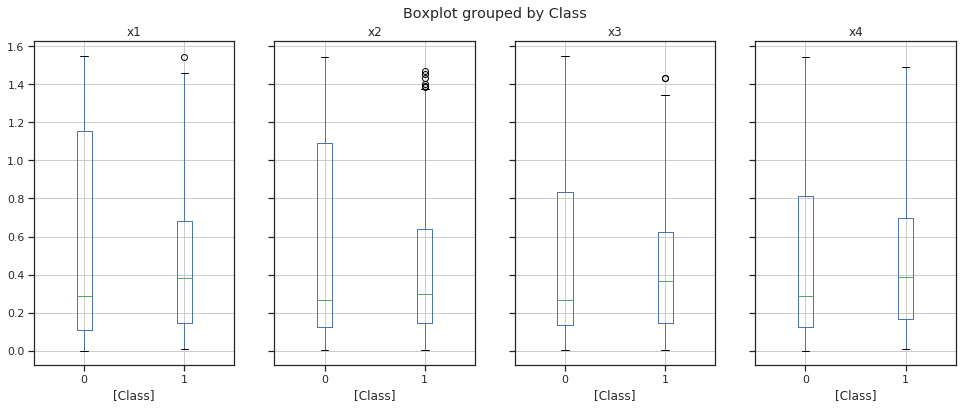

In [81]:
# boxplot of the statistics for each feature
boxplot = df.boxplot(column=['x1', 'x2', 'x3', 'x4'], by=['Class'], figsize=(16,6), layout=(1,4))

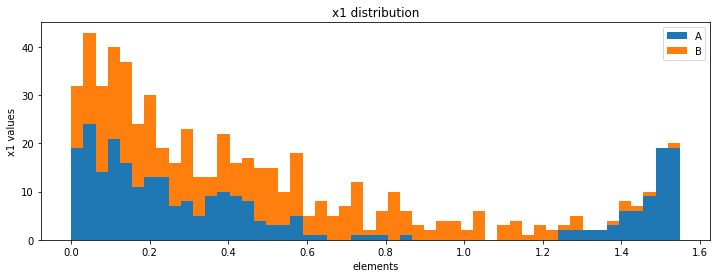

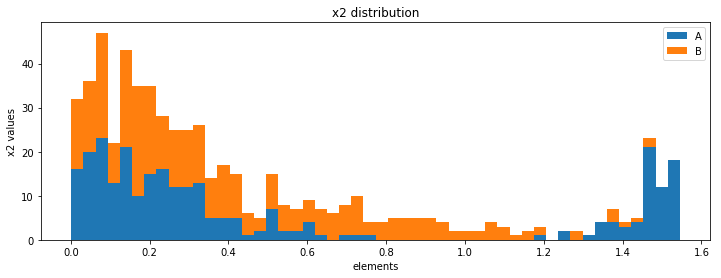

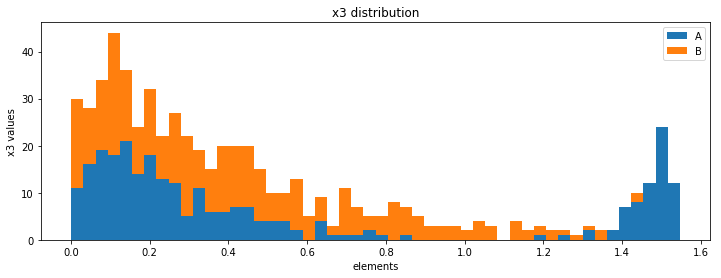

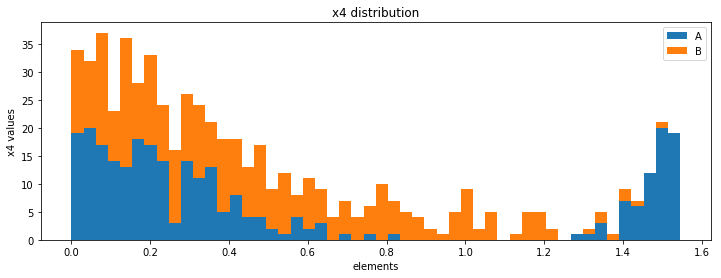

In [59]:
# distribution of features by category

bins = 50
for n, xi in enumerate(df.columns[0:4]):
    
    f, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))
    
    ax.hist([df_A[xi],df_B[xi]], bins = bins, stacked=True)
    ax.set_title(str(xi)+' distribution')
    ax.set_ylabel(str(xi) +' values')
    ax.legend(('A','B'))
    
    plt.xlabel('elements')
    plt.show()

/home/ginevracoal/venv/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


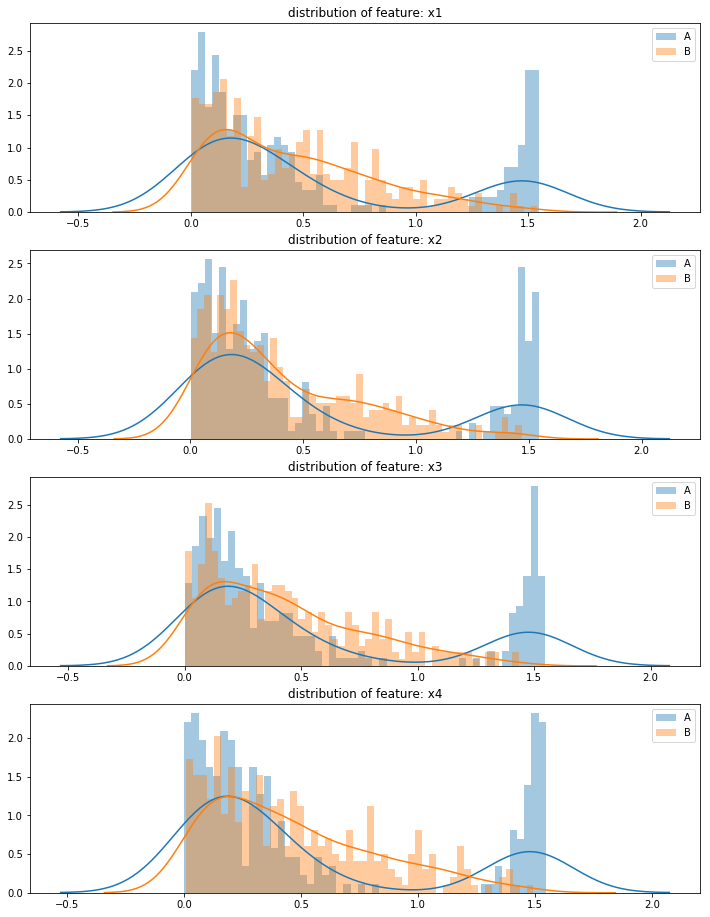

In [61]:
# better plot of the distribution of features in each category

plt.figure(figsize=(12,4*4))
gs = gridspec.GridSpec(4, 1)
for i, xi in enumerate(df.columns[0:4]):
    ax = plt.subplot(gs[i])
    sns.distplot(df_A[xi], bins=50)
    sns.distplot(df_B[xi], bins=50)
    ax.set_xlabel('')
    ax.set_title('distribution of feature: ' + str(xi))
    ax.legend(('A','B'))
plt.show()

## Correlation between features

/home/ginevracoal/venv/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


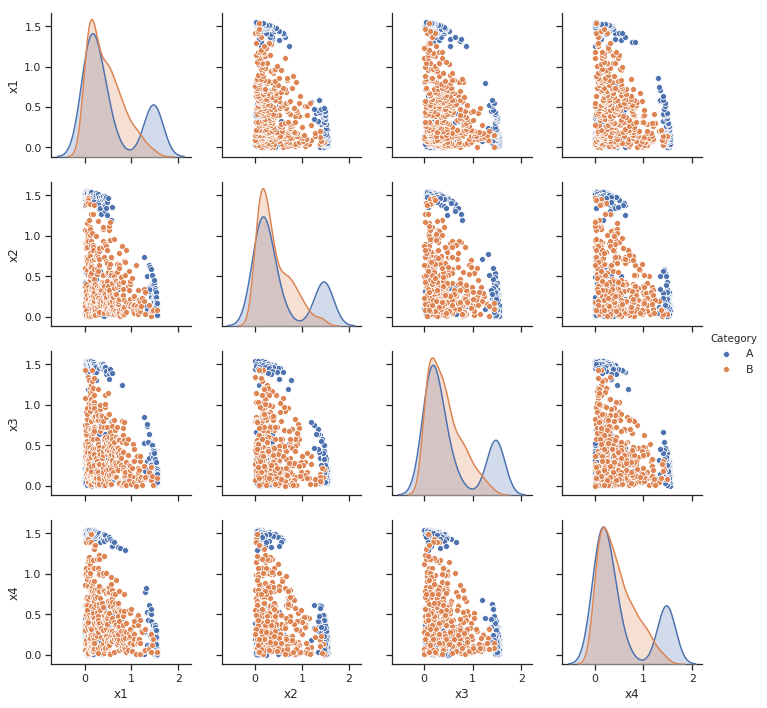

In [71]:
# correlation plot for the features
sns.set(style="ticks")
sns.pairplot(data.drop(data.columns[0],axis=1), hue="Category")

## Transforming and combining features

### Multiple linear regression

In [71]:
# Now we only need features
X = df.drop("Class",axis=1)

# normalizing features
X = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
#pd.DataFrame(X).describe() # check

# I want to regress x4 using the first 3 columns
X = df.iloc[:,0:3]
y = df['x4']

# Linear regression
reg = LinearRegression().fit(X,y)
print("Regression score: ",reg.score(X,y))
print('\nLinear fit coefficients: ', reg.coef_)

Regression score:  0.7494652163426967

Linear fit coefficients:  [-0.80234286 -0.79147518 -0.78828562]


In [7]:
import statsmodels.api as sm
fit = sm.OLS(y, X).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     x4   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     66.93
Date:                Sat, 01 Dec 2018   Prob (F-statistic):           2.13e-37
Time:                        13:48:10   Log-Likelihood:                -538.67
No. Observations:                 610   AIC:                             1083.
Df Residuals:                     607   BIC:                             1097.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2353      0.039      5.969      0.000       0.158       0.313
x2             0.2007      0.041      4.905      0.000       0.120       0.281
x3             0.2259      0.041      5.531      0.000       0.146       0.306
==============================================================================
Omnibus:                       79.766   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.866
Skew:                           1.041   Prob(JB):                     8.43e-25
Kurtosis:                       2.838   Cond. No.                         1.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

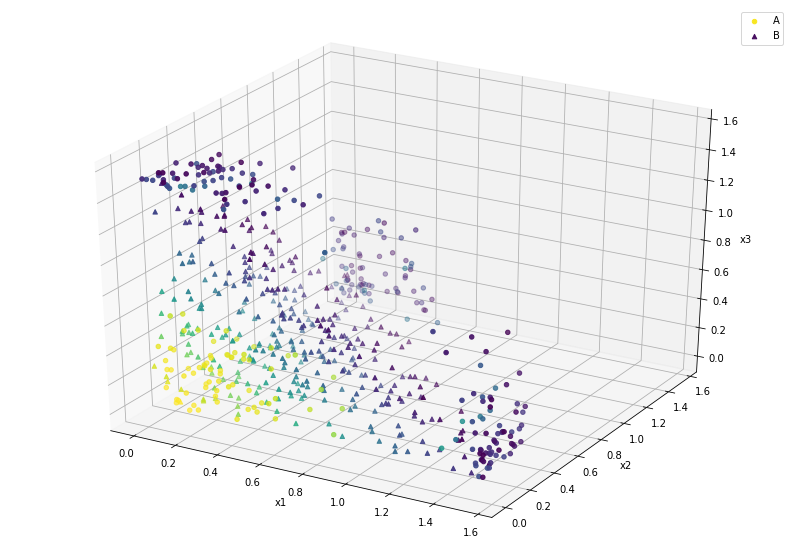

In [59]:
# plotting the first 3 componets in the 3d space.
# color corresponds to column 4 values, while shape to A-B classification
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (14,10))
ax = fig.add_subplot(111, projection='3d')


ax.scatter3D(df_A["x1"], df_A["x2"], df_A["x3"], c=df_A["x4"], marker="o")
ax.scatter3D(df_B["x1"], df_B["x2"], df_B["x3"], c=df_B["x4"], marker="^")

ax.legend(("A","B"))
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')

plt.show()

### Multiple regression plot

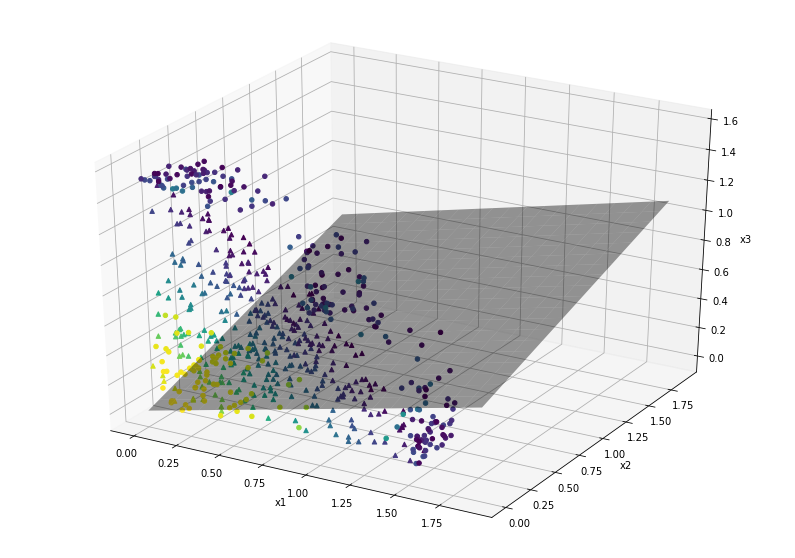

In [111]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
from matplotlib import cm

# multiple regression
X = df[['x1','x2','x3']]
y = df['x4']

#fit = sm.OLS(y, X).fit()

fig = plt.figure(figsize = (14,10))
ax = fig.add_subplot(111, projection='3d')



x_surf = np.arange(0, 2, .1)                # generate a mesh
y_surf = np.arange(0, 2, .1)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)

exog = pd.core.frame.DataFrame({'x1': x_surf.ravel(), 'x2': y_surf.ravel()})

out = fit.predict(exog = exog)
ax.plot_surface(x_surf, y_surf,
                out.values.reshape(x_surf.shape),
                rstride=1,
                cstride=1,
                color='None',
                alpha = 0.4)

ax.scatter(df_A['x1'], df_A['x2'], df_A['x3'], c=df_A['x4'], marker='o', alpha=1)
ax.scatter(df_B['x1'], df_B['x2'], df_B['x3'], c=df_B['x4'], marker='^', alpha=1)

#ax.legend(("A","B"))
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')

plt.show()


### Best fitting curve

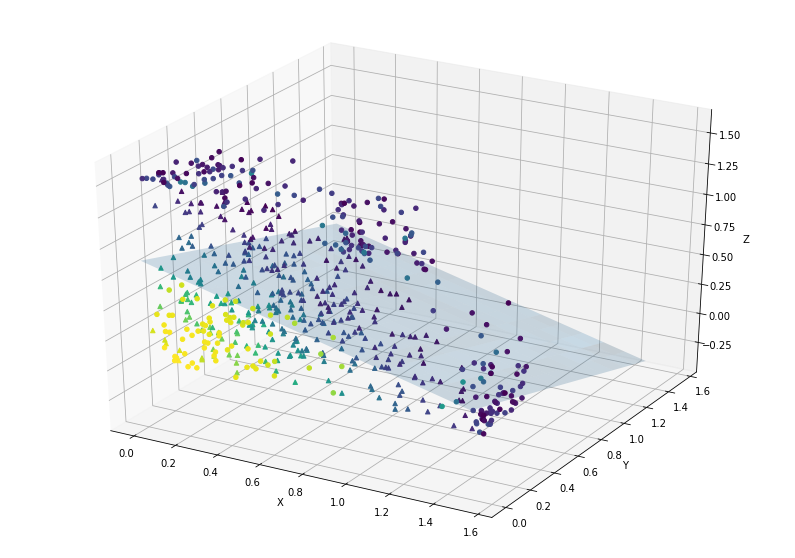

In [127]:

import scipy.linalg

# some 3-dim points
mean = np.array([0.0,0.0,0.0])
cov = np.array([[1.0,-0.5,0.8], [-0.5,1.1,0.0], [0.8,0.0,1.0]])
data = np.random.multivariate_normal(mean, cov, 50)

# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(0.0, 1.6, 0.1), np.arange(0.0, 1.6, 0.1))
XX = X.flatten()
YY = Y.flatten()

order = 1    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[df['x1'], df['x2'], np.ones(df.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, df['x3'])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(df.shape[0]), df[:,:2], np.prod(df[:,:2], axis=1), df[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, df[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

# plot points and fitted surface
fig = plt.figure(figsize = (14,10))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(df_A['x1'], df_A['x2'], df_A['x3'], c=df_A['x4'], marker='o', alpha=1)
ax.scatter(df_B['x1'], df_B['x2'], df_B['x3'], c=df_B['x4'], marker='^', alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')
ax.axis('tight')
plt.show()

### PCA

In [105]:
pca.components_

array([[-0.56570361,  0.61727692,  0.37100914, -0.40162277],
       [-0.64691445, -0.0707311 , -0.04846456,  0.75772686],
       [-0.08945137, -0.60761515,  0.7848129 , -0.08289143]])

In [112]:
X = df.iloc[:,0:4]

# normalization
X = X.values
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

princ_df = pd.DataFrame(data = X_pca
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
princ_df.head()

,principal component 1,principal component 2,principal component 3
0,-0.333035,0.714088,-0.045977
1,-0.237314,0.691919,-0.209217
2,0.463238,0.262886,-0.405577
3,0.571059,0.144795,-0.409817
4,0.486473,-0.002743,0.303845


In [170]:
print("explained variance ratio:          \t",pca.explained_variance_ratio_)
print("explained variance cumulative sum: \t",np.cumsum(pca.explained_variance_ratio_))

explained variance ratio:          	 [0.34046855 0.33098486 0.30960732]
explained variance cumulative sum: 	 [0.34046855 0.67145341 0.98106073]


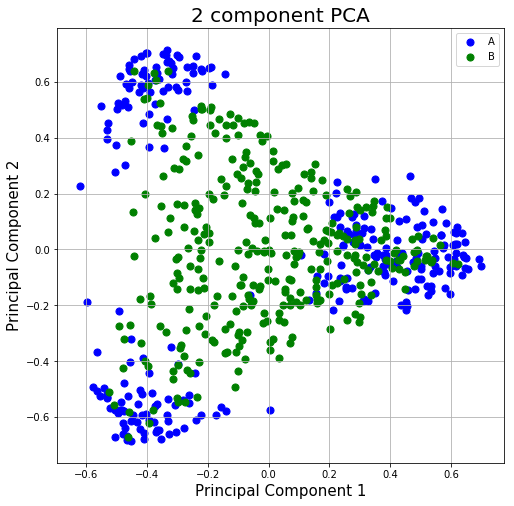

In [171]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

# adding back targets to features
princ_df = pd.concat([princ_df, df[['Category']]], axis = 1)
targets = ['A','B']
colors = ['b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = princ_df['Category'] == target
    ax.scatter(princ_df.loc[indicesToKeep, 'principal component 1']
               , princ_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
# 3d representation
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode()

# pca projections 3d plot

categories = df['Category']
trace1 = []
trace2 = []

for i in range(len(X_pca)):
    # each trace should contain only the elements from one of the two categories
    trace1 = go.Scatter3d(x=X_pca[categories=='A', 0], 
                          y=X_pca[categories=='A', 1],
                          z=X_pca[categories=='A', 2],
                                 mode='markers',
                                 showlegend=False,
                                 marker=dict(color='blue',
                                             line=dict(color='black', width=1))
                                )

    
    trace2 = go.Scatter3d(x=X_pca[categories=='B', 0], 
                          y=X_pca[categories=='B', 1],
                          z=X_pca[categories=='B', 2],
                                 mode='markers',
                                 showlegend=False,
                                 marker=dict(color='green',
                                             line=dict(color='black', width=1))
                                )

fig = go.Figure(data=[trace1,trace2])  
iplot(fig)

## Kernel PCA
Is it necessary?

In [5]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

In [6]:
np.random.seed(0)

# Separating out the features
X = df.iloc[:,0:4].values
# Separating out the target
y = df.loc[:,['Category']].values
# Standardizing the features
X = StandardScaler().fit_transform(X)

In [ ]:
kpca = KernelPCA(kernel="rbf",gamma=0.00000000001, degree=6, alpha=2.0)
X_kpca = kpca.fit_transform(X)

# 3d representation
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode()

# pca projections 3d plot

categories = df['Category']
trace1 = []
trace2 = []

for i in range(len(X_kpca)):
    # each trace should contain only the elements from one of the two categories
    trace1 = go.Scatter3d(x=X_kpca[categories=='A', 0], 
                          y=X_kpca[categories=='A', 1],
                          z=X_kpca[categories=='A', 2],
                                 mode='markers',
                                 showlegend=False,
                                 marker=dict(color='blue',
                                             line=dict(color='black', width=1))
                                )

    
    trace2 = go.Scatter3d(x=X_kpca[categories=='B', 0], 
                          y=X_kpca[categories=='B', 1],
                          z=X_kpca[categories=='B', 2],
                                 mode='markers',
                                 showlegend=False,
                                 marker=dict(color='green',
                                             line=dict(color='black', width=1))
                                )

fig = go.Figure(data=[trace1,trace2])  
iplot(fig)

## Clustering

In [45]:
from sklearn.cluster import KMeans

In [117]:
df['Bool']= pd.factorize(df['Category'])[0]
bool_df = df.drop(columns='Category')
bool_df.head()

,x1,x2,x3,x4,Bool
0,0.000345,0.152103,0.201556,1.529294,0
1,0.000837,0.426073,0.086737,1.487763,0
2,0.002193,1.379352,0.340120,0.619839,0
3,0.006689,1.457914,0.366887,0.377273,0
4,0.006799,0.602755,1.079031,0.061415,1


In [122]:
data = df.iloc[:,0:4]

#number of clusters
kmeans = KMeans(n_clusters=2)

# Fitting the input data
kmeans = kmeans.fit(data)

# Getting the cluster labels
labels = kmeans.predict(data)

# Centroid values
centroids = kmeans.cluster_centers_


In [119]:
df_A = df[df['Category']=='A']
df_B = df[df['Category']=='B']

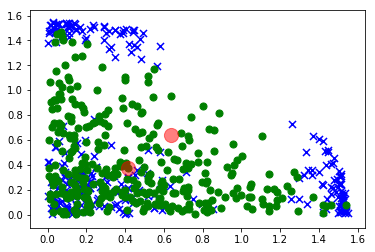

In [121]:
plt.scatter(df_A.iloc[:, 0], df_A.iloc[:, 1], c='blue', s=50, cmap='viridis', marker='x')
plt.scatter(df_B.iloc[:, 0], df_B.iloc[:, 1], c='green', s=50, cmap='viridis', marker='o')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.5)
#plt.scatter(bool_df.iloc[:, 0], bool_df.iloc[:, 1], c=labels, s=50, cmap='viridis', marker='^')

## Distribution of features

In [137]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

In [170]:
def check_distributions(data):
    matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
    matplotlib.style.use('ggplot')

    # Create models from data
    def best_fit_distribution(data, bins=200, ax=None):
        """Model data by finding best fit distribution to data"""
        # Get histogram of original data
        y, x = np.histogram(data, bins=bins, density=True)
        x = (x + np.roll(x, -1))[:-1] / 2.0

        # Distributions to check
        DISTRIBUTIONS = [        
            st.alpha,st.arcsine,st.beta,st.cauchy,st.chi,st.chi2,st.cosine,st.expon,st.f,
            st.gamma,st.invgamma,st.invgauss,
            st.laplace,
            st.logistic,st.lognorm,
            st.norm,st.pareto,
            st.t,
            st.uniform,st.wald
        ]

        # Best holders
        best_distribution = st.norm
        best_params = (0.0, 1.0)
        best_sse = np.inf

        # Estimate distribution parameters from data
        for distribution in DISTRIBUTIONS:

            # Try to fit the distribution
            try:
                # Ignore warnings from data that can't be fit
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore')

                    # fit dist to data
                    params = distribution.fit(data)

                    # Separate parts of parameters
                    arg = params[:-2]
                    loc = params[-2]
                    scale = params[-1]

                    # Calculate fitted PDF and error with fit in distribution
                    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                    sse = np.sum(np.power(y - pdf, 2.0))

                    # if axis pass in add to plot
                    try:
                        if ax:
                            pd.Series(pdf, x).plot(ax=ax)
                        end
                    except Exception:
                        pass

                    # identify if this distribution is better
                    if best_sse > sse > 0:
                        best_distribution = distribution
                        best_params = params
                        best_sse = sse

            except Exception:
                pass

        return (best_distribution.name, best_params)

    def make_pdf(dist, params, size=10000):
        """Generate distributions's Probability Distribution Function """

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Get sane start and end points of distribution
        start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
        end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

        # Build PDF and turn into pandas Series
        x = np.linspace(start, end, size)
        y = dist.pdf(x, loc=loc, scale=scale, *arg)
        pdf = pd.Series(y, x)

        return pdf

    # Load data from statsmodels datasets
     #data = df.iloc[:,1]

    # Plot for comparison
    plt.figure(figsize=(12,8))
    ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5)#color=plt.rcParams['axes.color_cycle'][1])
    # Save plot limits
    dataYLim = ax.get_ylim()

    # Find best fit distribution
    best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
    best_dist = getattr(st, best_fit_name)

    # Update plots
    ax.set_ylim(dataYLim)
    ax.set_xlim(0,2)
    ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
    ax.set_xlabel(u'Temp (°C)')
    ax.set_ylabel('Frequency')

    # Make PDF with best params 
    pdf = make_pdf(best_dist, best_fit_params)

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    ax.set_xlim(0,2)
    ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
    ax.set_xlabel(u'Temp. (°C)')
    ax.set_ylabel('Frequency')

/home/ginevracoal/venv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



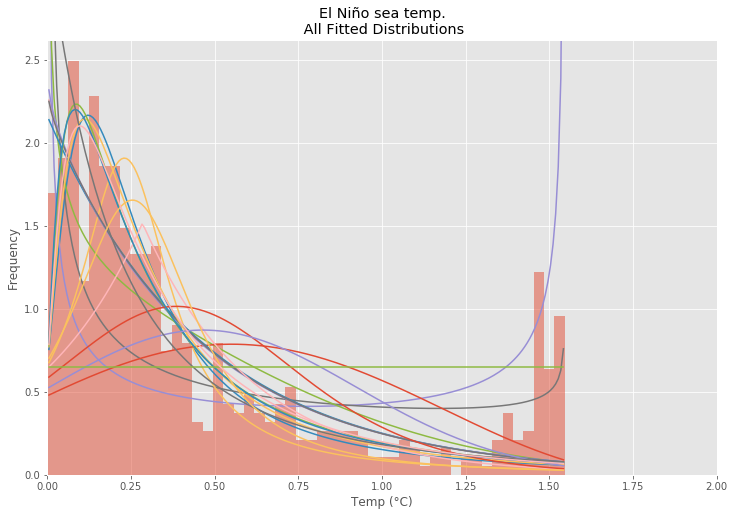

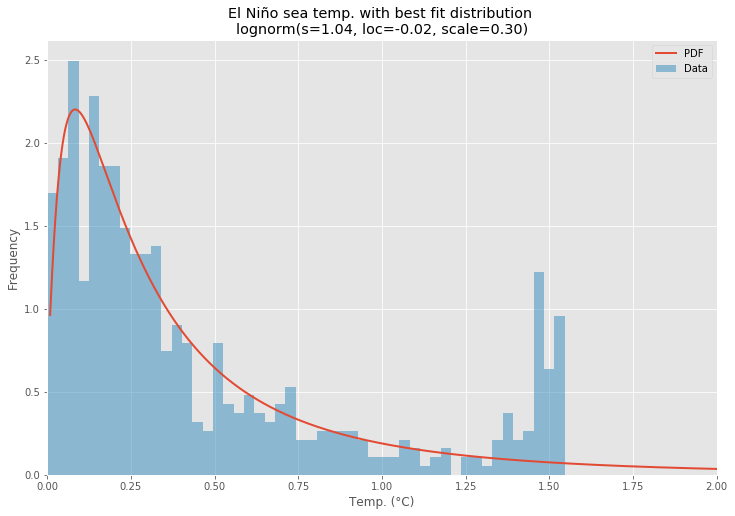

In [171]:
check_distributions(df.iloc[:,1])

/home/ginevracoal/venv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



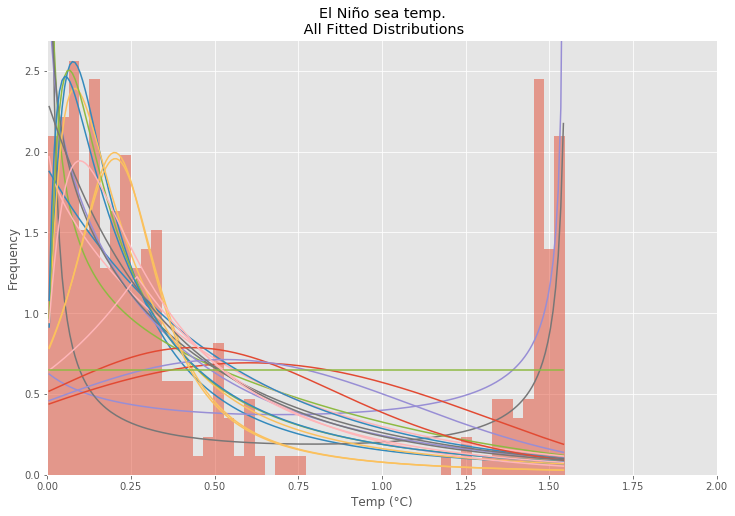

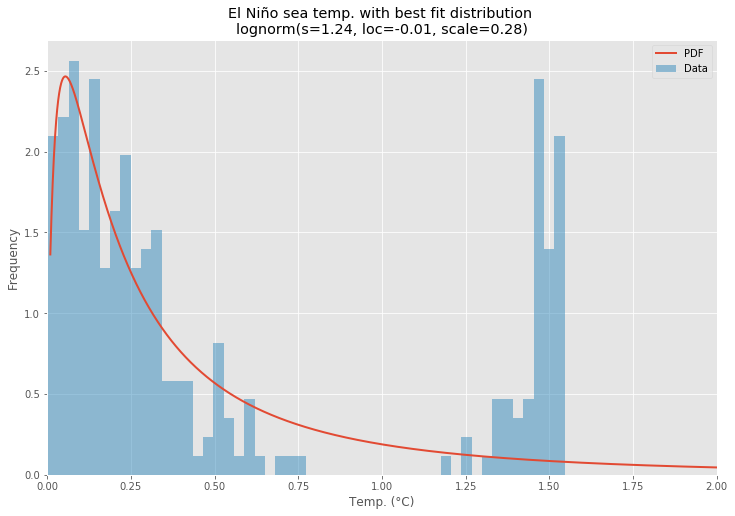

In [173]:
check_distributions(df_A.iloc[:,1])

/home/ginevracoal/venv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



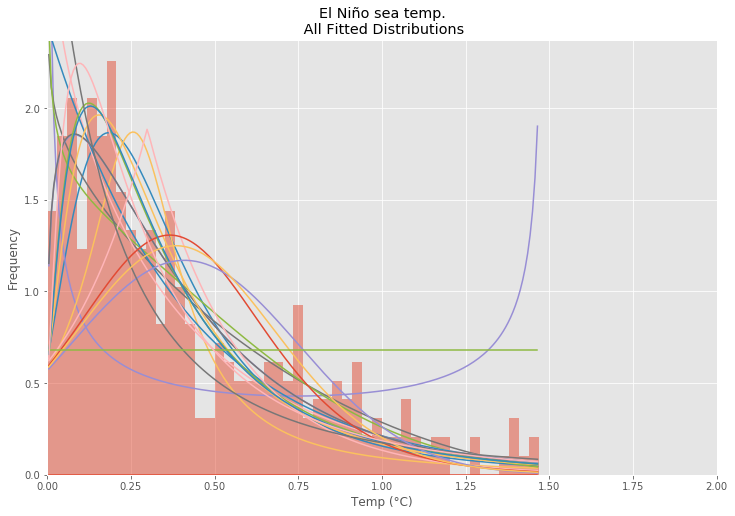

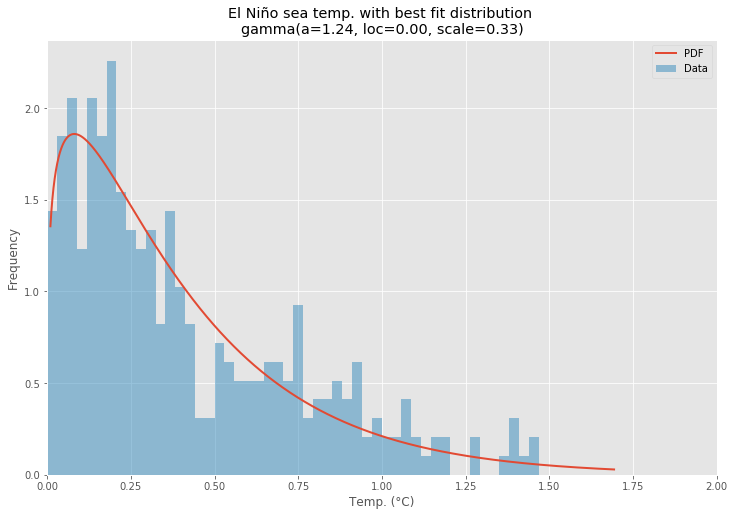

In [174]:
check_distributions(df_B.iloc[:,1])